In [210]:
import pandas as pd
from holidays import UnitedStates
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import calendar
import scipy.stats as stats
from scipy.stats import spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pingouin as pg
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc,precision_score, recall_score, f1_score, mean_squared_error, classification_report
from statsmodels.tsa.arima.model import ARIMA
import os

In [211]:
dataset = pd.read_csv("Datasets Folder/dataset_updated.csv")
select = (dataset.columns).drop('isHoliday')
dataset = dataset[select]
dataset

,timestamp,value,month,day,hour,minute,day_of_week,isWeekend,isAnomaly,Holiday,prep,snow,snow_depth,min_temp,max_temp,TotalMinutes,season
0,2014-07-01 00:00:00,10844.0,7,1,0,0,Tuesday,False,False,NaN,0.00,0.0,0.0,72.0,89.0,0,Summer
1,2014-07-01 00:30:00,8127.0,7,1,0,30,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,30,Summer
2,2014-07-01 01:00:00,6210.0,7,1,1,0,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,60,Summer
3,2014-07-01 01:30:00,4656.0,7,1,1,30,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,90,Summer
4,2014-07-01 02:00:00,3820.0,7,1,2,0,Tuesday,False,False,NaN,NaN,NaN,NaN,NaN,NaN,120,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,1,31,22,0,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,1320,Winter
10317,2015-01-31 22:30:00,27309.0,1,31,22,30,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,1350,Winter
10318,2015-01-31 23:00:00,26591.0,1,31,23,0,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,1380,Winter
10319,2015-01-31 23:30:00,26288.0,1,31,23,30,Saturday,True,False,NaN,NaN,NaN,NaN,NaN,NaN,1410,Winter


In [212]:
# Replace all unique non-null values in 'Holiday' with 1
unique_holiday = list(dataset['Holiday'].loc[~dataset['Holiday'].isnull()])
dataset['Holiday'].replace(unique_holiday, 1, inplace=True)

# Fill missing values in 'Holiday' with 0
dataset['Holiday'].fillna(0, inplace=True)

# Rename column 'Holiday' to 'isHoliday'
dataset.rename(columns={'Holiday': 'isHoliday'}, inplace=True)

# Display the first few rows of the dataset
dataset.head()


C:\Users\weare\AppData\Local\Temp\ipykernel_17308\2002410920.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Holiday'].replace(unique_holiday, 1, inplace=True)
C:\Users\weare\AppData\Local\Temp\ipykernel_17308\2002410920.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Holid

,timestamp,value,month,day,hour,minute,day_of_week,isWeekend,isAnomaly,isHoliday,prep,snow,snow_depth,min_temp,max_temp,TotalMinutes,season
0,2014-07-01 00:00:00,10844.0,7,1,0,0,Tuesday,False,False,0.0,0.0,0.0,0.0,72.0,89.0,0,Summer
1,2014-07-01 00:30:00,8127.0,7,1,0,30,Tuesday,False,False,0.0,NaN,NaN,NaN,NaN,NaN,30,Summer
2,2014-07-01 01:00:00,6210.0,7,1,1,0,Tuesday,False,False,0.0,NaN,NaN,NaN,NaN,NaN,60,Summer
3,2014-07-01 01:30:00,4656.0,7,1,1,30,Tuesday,False,False,0.0,NaN,NaN,NaN,NaN,NaN,90,Summer
4,2014-07-01 02:00:00,3820.0,7,1,2,0,Tuesday,False,False,0.0,NaN,NaN,NaN,NaN,NaN,120,Summer


In [213]:
# Convert 'timestamp' to datetime and set as index
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.set_index("timestamp", inplace=True)

# Columns to interpolate
columns_to_interpolate = ['prep', 'snow', 'snow_depth', 'min_temp', 'max_temp']
dataset[columns_to_interpolate] = dataset[columns_to_interpolate].interpolate(method='time')

# Drop specific row
dataset = dataset.drop(pd.Timestamp('2015-02-01 00:00:00'), axis=0)

# Convert numeric month to full month names
dataset["month"] = dataset["month"].apply(lambda x: calendar.month_name[x])

# Convert 'value' column to integer
dataset['value'] = dataset['value'].astype(int)

# Display the DataFrame
dataset

dataset

,value,month,day,hour,minute,day_of_week,isWeekend,isAnomaly,isHoliday,prep,snow,snow_depth,min_temp,max_temp,TotalMinutes,season
timestamp,,,,,,,,,,,,,,,,
2014-07-01 00:00:00,10844,July,1,0,0,Tuesday,False,False,0.0,0.000000,0.00000,0.000,72.000000,89.000000,0,Summer
2014-07-01 00:30:00,8127,July,1,0,30,Tuesday,False,False,0.0,0.020000,0.00000,0.000,72.000000,89.041667,30,Summer
2014-07-01 01:00:00,6210,July,1,1,0,Tuesday,False,False,0.0,0.040000,0.00000,0.000,72.000000,89.083333,60,Summer
2014-07-01 01:30:00,4656,July,1,1,30,Tuesday,False,False,0.0,0.060000,0.00000,0.000,72.000000,89.125000,90,Summer
2014-07-01 02:00:00,3820,July,1,2,0,Tuesday,False,False,0.0,0.080000,0.00000,0.000,72.000000,89.166667,120,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-31 21:30:00,24670,January,31,21,30,Saturday,True,False,0.0,0.026875,0.26875,6.025,19.270833,34.958333,1290,Winter
2015-01-31 22:00:00,25721,January,31,22,0,Saturday,True,False,0.0,0.027500,0.27500,6.000,19.416667,35.166667,1320,Winter
2015-01-31 22:30:00,27309,January,31,22,30,Saturday,True,False,0.0,0.028125,0.28125,5.975,19.562500,35.375000,1350,Winter


In [214]:
dataset['hour'] = (dataset['hour']) % 24
dataset = dataset[dataset.columns.drop(["TotalMinutes","minute","prep","snow_depth","snow"])]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        10320 non-null  int64  
 1   month        10320 non-null  object 
 2   day          10320 non-null  int64  
 3   hour         10320 non-null  int64  
 4   day_of_week  10320 non-null  object 
 5   isWeekend    10320 non-null  bool   
 6   isAnomaly    10320 non-null  bool   
 7   isHoliday    10320 non-null  float64
 8   min_temp     10320 non-null  float64
 9   max_temp     10320 non-null  float64
 10  season       10320 non-null  object 
dtypes: bool(2), float64(3), int64(3), object(3)
memory usage: 826.4+ KB


In [215]:
dataset.describe()

,value,day,hour,isHoliday,min_temp,max_temp
count,10320.000000,10320.000000,10320.000000,10320.00000,10320.000000,10320.000000
mean,15137.569380,15.860465,11.500000,0.04186,49.797868,63.000242
std,6939.495808,8.867881,6.922522,0.20028,17.166381,18.863386
min,8.000000,1.000000,0.000000,0.00000,8.000000,21.000000
25%,10262.000000,8.000000,5.750000,0.00000,34.958333,44.750000
50%,16778.000000,16.000000,11.500000,0.00000,52.250000,66.416667
75%,19838.750000,24.000000,17.250000,0.00000,65.484375,80.916667
max,39197.000000,31.000000,23.000000,1.00000,77.000000,92.000000


In [216]:
dataset

,value,month,day,hour,day_of_week,isWeekend,isAnomaly,isHoliday,min_temp,max_temp,season
timestamp,,,,,,,,,,,
2014-07-01 00:00:00,10844,July,1,0,Tuesday,False,False,0.0,72.000000,89.000000,Summer
2014-07-01 00:30:00,8127,July,1,0,Tuesday,False,False,0.0,72.000000,89.041667,Summer
2014-07-01 01:00:00,6210,July,1,1,Tuesday,False,False,0.0,72.000000,89.083333,Summer
2014-07-01 01:30:00,4656,July,1,1,Tuesday,False,False,0.0,72.000000,89.125000,Summer
2014-07-01 02:00:00,3820,July,1,2,Tuesday,False,False,0.0,72.000000,89.166667,Summer
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-31 21:30:00,24670,January,31,21,Saturday,True,False,0.0,19.270833,34.958333,Winter
2015-01-31 22:00:00,25721,January,31,22,Saturday,True,False,0.0,19.416667,35.166667,Winter
2015-01-31 22:30:00,27309,January,31,22,Saturday,True,False,0.0,19.562500,35.375000,Winter


# Analysis

## Temporality & Dimensionality

In [217]:
print(dataset.columns)

dataset.index

Index(['value', 'month', 'day', 'hour', 'day_of_week', 'isWeekend',
       'isAnomaly', 'isHoliday', 'min_temp', 'max_temp', 'season'],
      dtype='object')


DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [218]:
is_sorted = dataset.index.is_monotonic_increasing
print(f"Is the dataset sorted by time? {is_sorted}")


Is the dataset sorted by time? True


In [219]:
print(dataset.shape)

(10320, 11)


In [220]:
if dataset.shape[1] == 1:
    print("Univariate time series")
else:
    print("Multivariate time series")

Multivariate time series


## Total taxi passengers & all the weathers features by specific times group

Variables:
- value

Visualisations:
- Throughout all the data
- By each month
- By each day_of_week
- By each isWeekend

### Variable "value"

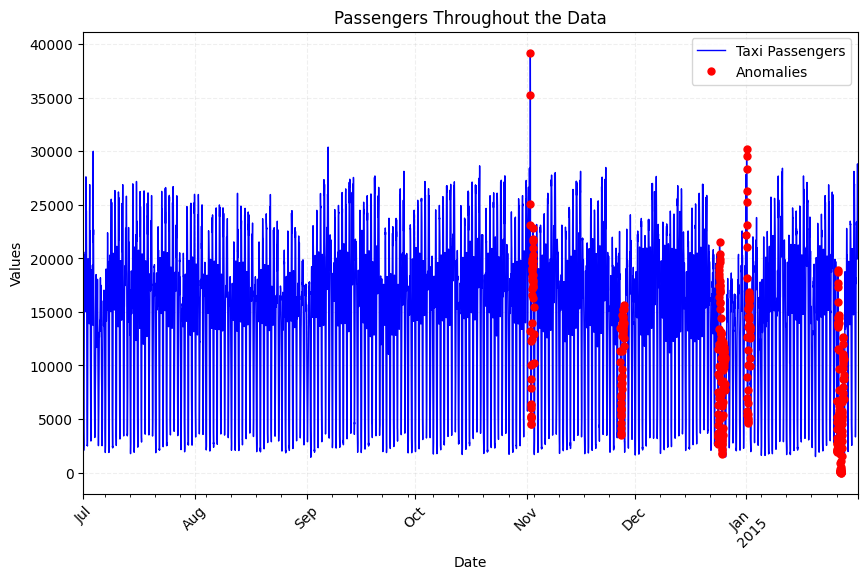

In [221]:
def make_graph(interval=None, col = 'value'):
    # Plotting the main "value" series
    if interval is None:
        graph = dataset[col]
        anomaly = dataset.loc[dataset['isAnomaly'], col]
        title = 'Passengers Throughout the Data'
    else:
        start, end = interval  # Unpack the start and end dates
        graph = dataset.loc[start:end, col]
        anomaly = dataset.loc[
            (dataset.index >= start) & (dataset.index <= end) & (dataset['isAnomaly']),
            'value'
        ]
        title = f'Passengers from {start} to {end}'

    # Plot the main graph
    graph.plot(figsize=(10, 6), color='blue', linewidth=1, label='Taxi Passengers')

    # Plot anomalies if they exist
    if not anomaly.empty:
        anomaly.plot(
            linestyle='None',
            marker='o',
            color='red',
            markersize=5,
            label='Anomalies'
        )

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)

    # Rotating x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adding a grid with some transparency
    plt.grid(True, linestyle='--', alpha=0.2)

    # Displaying the legend to differentiate the series
    plt.legend()

    # Show the plot
    plt.show()

# Throughout the data
make_graph()

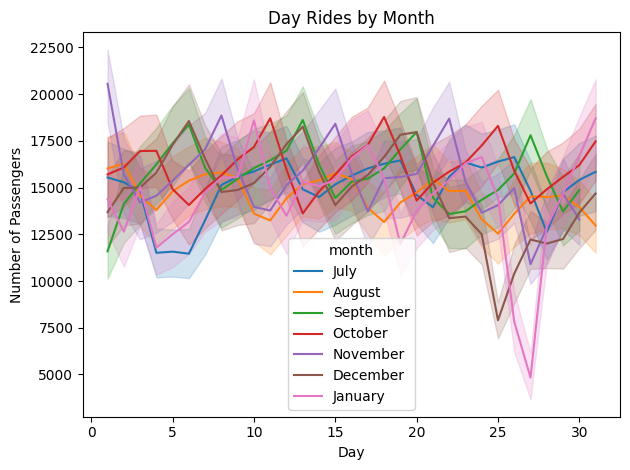

In [222]:
# By each months for every hours
sns.lineplot(
    x="day", 
    y="value",
    data=dataset,
    hue= "month")
plt.xlabel("Day")
plt.ylabel("Number of Passengers")
plt.title("Day Rides by Month")
plt.tight_layout()
plt.show()

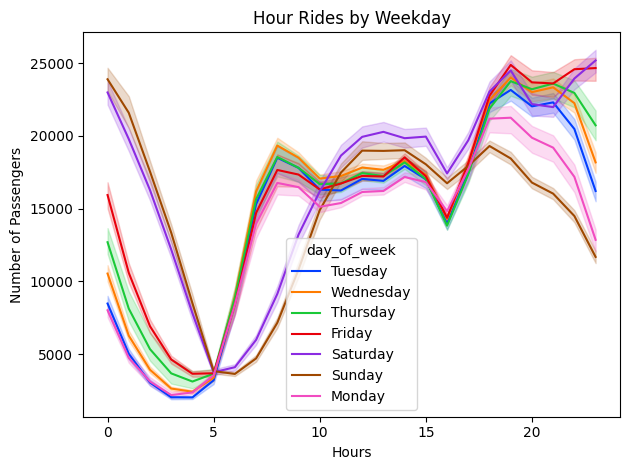

In [223]:
sns.lineplot(
    x="hour", 
    y="value",
    data=dataset,
    palette='bright',
    hue= "day_of_week")
plt.xlabel("Hours")
plt.ylabel("Number of Passengers")
plt.title("Hour Rides by Weekday")
plt.tight_layout()
plt.show()

## 3 consecutive normal and anomalous weeks

There are two detections that makes the dates are in anomaly
- The values in at least 1 data entry among the specified date range is over or under limits
- Not following usual patterns for the last 7 - 14 days

Specified problems with each anomalous date:
- 2 November 2014 (Annual Marathon): Limits
- 27 November 2014 (Thanksgiving): Wrong Patterns
- 24 & 25 December 2014 (Chritsmas): Wrong Patterns
- 1 January 2015 (New Years): Limits
- 26 & 27 January 2015 (Snowstorm): Limits & Wrong Patterns

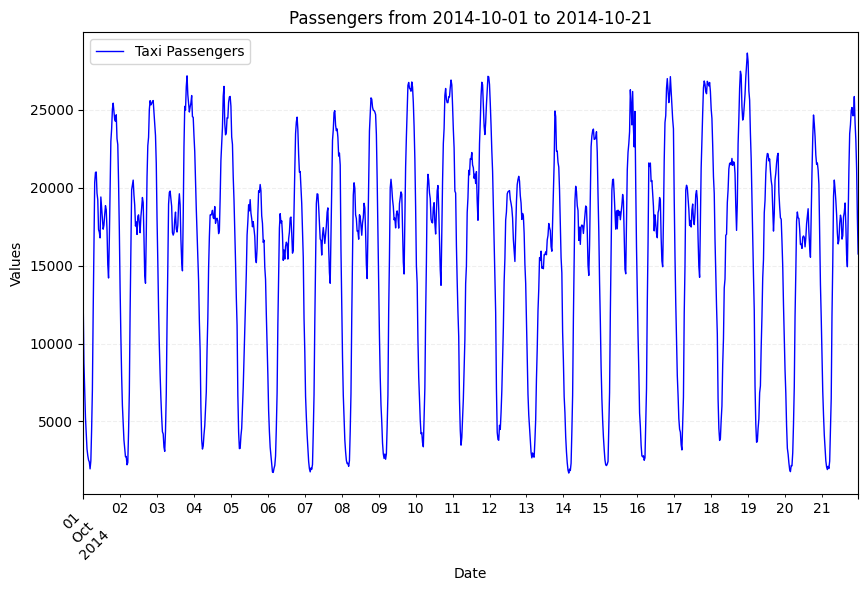

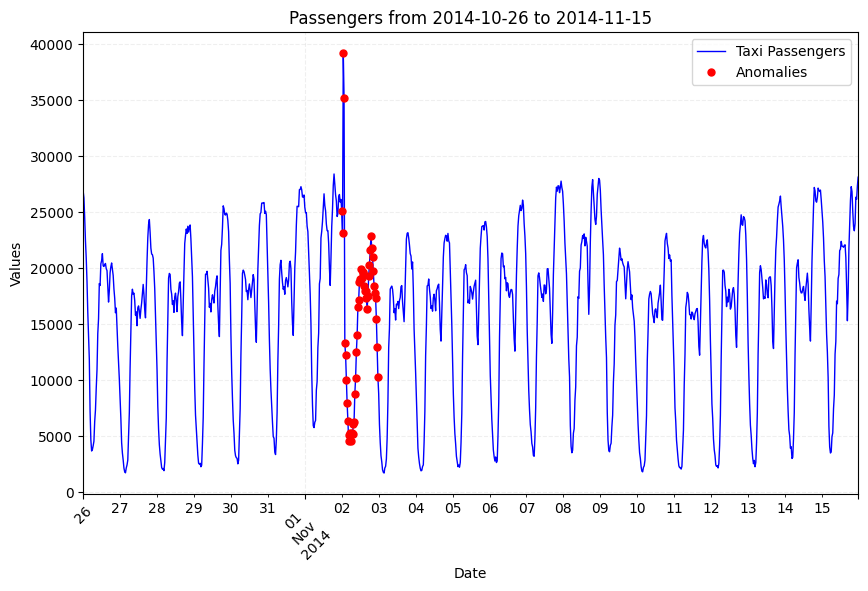

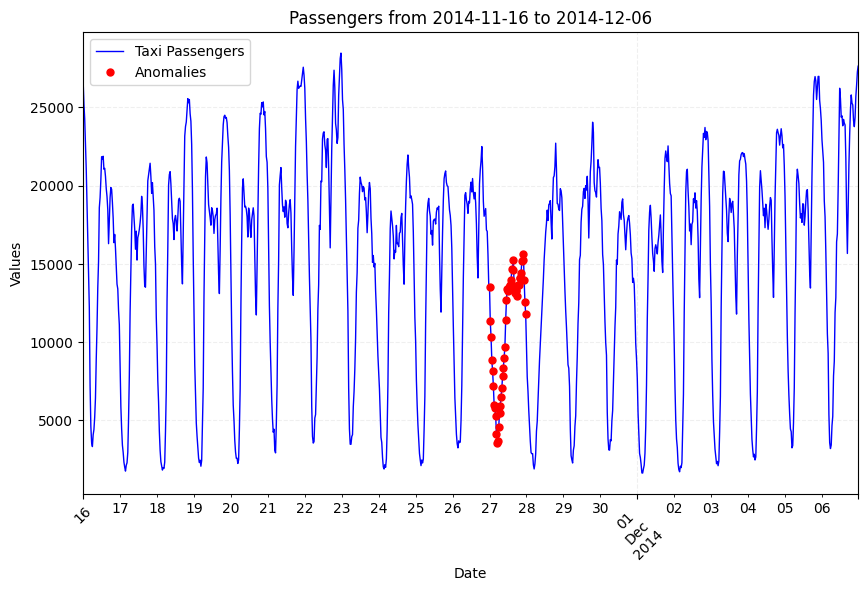

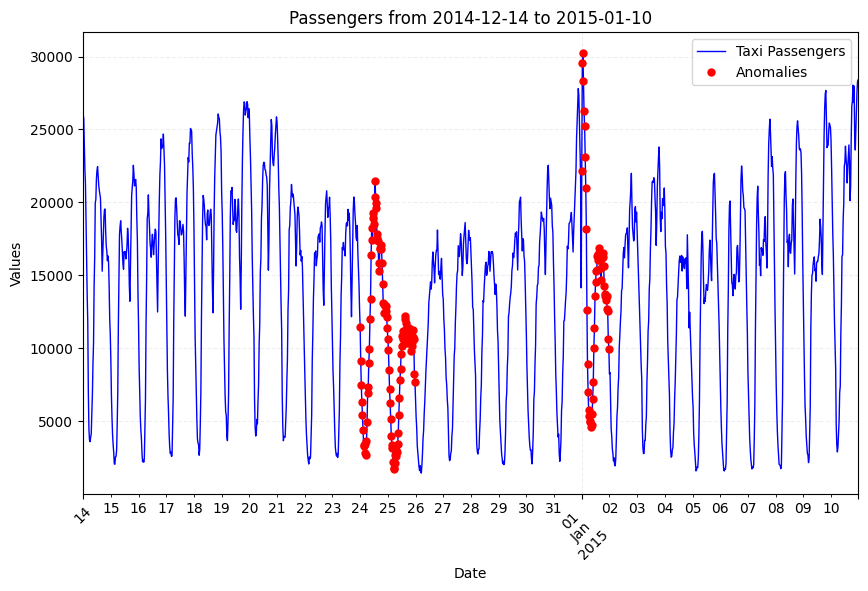

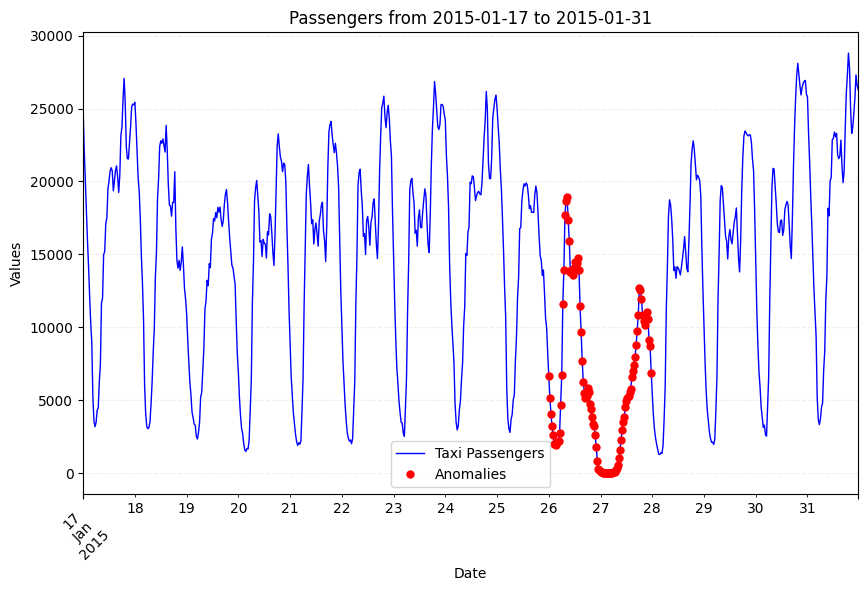

In [224]:
consicutive_weeks = [ 
        ['2014-10-01','2014-10-21'], # Normal
        ['2014-10-26','2014-11-15'], # Annual Marathon
        ['2014-11-16','2014-12-06'], # Thanksgiving
        ['2014-12-14','2015-01-10'], # Christmas and New Years
        ['2015-01-17','2015-01-31'] # Snowstorm
    ]
# Iterate over anomaly periods and plot
for interval in consicutive_weeks:
    make_graph(interval)

## Properties checking

- "value" feature are not in normal distribution
- value feature has autocorrelation in the series


- From ADF test,
    - the value feature is stationary
    - the isAnomaly feature is stationary

- From KPSS test,
    - the value feature is trend-stationary
    - the isAnomaly feature is non-trend-stationary

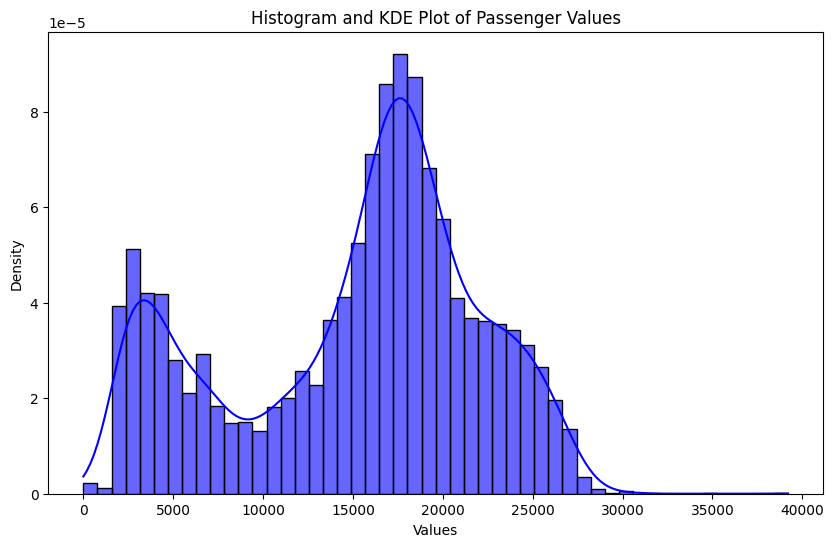

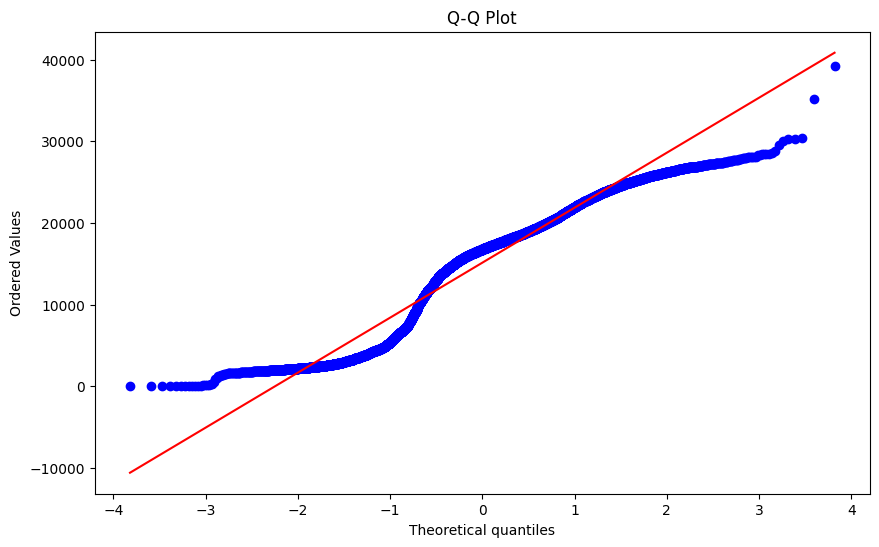

In [225]:
# Plot histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(dataset['value'], kde=True, bins=50, color='blue', stat='density', alpha=0.6)
plt.title('Histogram and KDE Plot of Passenger Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

# Generate Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(dataset['value'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

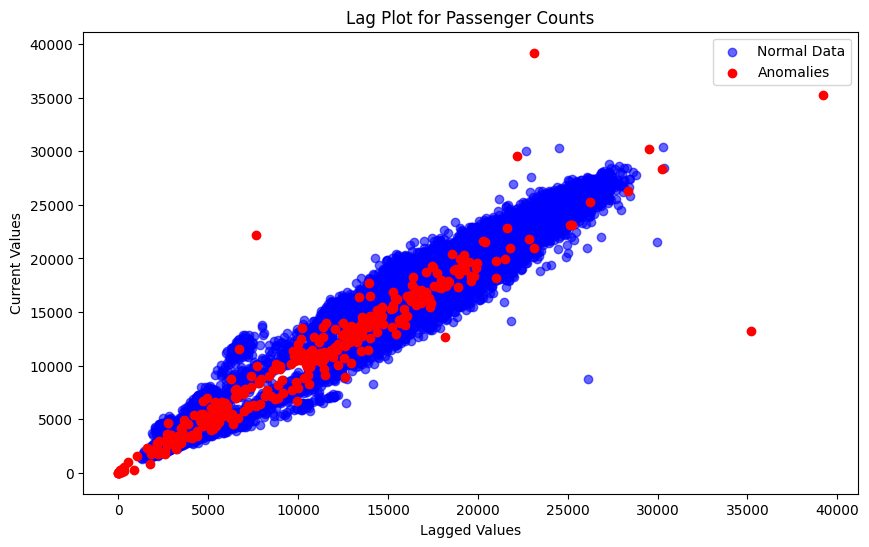

In [226]:
# Separate normal and anomaly data
normal_data = dataset[~dataset['isAnomaly']]  # Data without anomalies
anomaly_data = dataset[dataset['isAnomaly']]  # Data with anomalies

# Create lag plot
plt.figure(figsize=(10, 6))

# Plot normal data
plt.scatter(
    normal_data['value'][:-1],  # Lagging 'value'
    normal_data['value'][1:],   # Current 'value'
    color='blue', alpha=0.6, label='Normal Data'
)

# Plot anomaly data
plt.scatter(
    anomaly_data['value'][:-1],  # Lagging 'value'
    anomaly_data['value'][1:],   # Current 'value'
    color='red', label='Anomalies'
)

# Add plot title and legend
plt.title('Lag Plot for Passenger Counts')
plt.xlabel('Lagged Values')
plt.ylabel('Current Values')
plt.legend()

# Show the plot
plt.show()

In [227]:
# ADF Test
print("ADF Test")
print("Using on value")
result = adfuller(dataset['value'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')
print("\n")
print("Using on isAnomaly")
result = adfuller(dataset['isAnomaly'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Test
Using on value
ADF Statistic: -10.764517454017037
p-value: 2.4721317220666687e-19
Critical Values:
   1%, -3.4309862775905664
Critical Values:
   5%, -2.8618211976893573
Critical Values:
   10%, -2.566919676386092


Using on isAnomaly
ADF Statistic: -8.942148235384224
p-value: 9.191722701586968e-15
Critical Values:
   1%, -3.4309838722215322
Critical Values:
   5%, -2.8618201347695615
Critical Values:
   10%, -2.566919110593691


In [228]:
# KPSS Test
print("KPSS Test")
print("Using on value")
result = kpss(dataset['value'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print("Using on isAnomaly")
result = kpss(dataset['isAnomaly'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

KPSS Test
Using on value

KPSS Statistic: 0.418064
p-value: 0.069369
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
Using on isAnomaly

KPSS Statistic: 1.079606
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


C:\Users\weare\AppData\Local\Temp\ipykernel_17308\2800864707.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(dataset['isAnomaly'], regression='c')


## Seasonality and Trends

- Observed:
    - The original dataset
- Trends:
    - reflects the long-term movement in the data
    - shows the underlying increase or decrease in passenger counts over time.
    - Our data shows the repeated patterns - weekly trends
- Seasonal:
    - captures the repeated patterns or cycles in the data (e.g., daily, weekly, or monthly seasonality)
    - Can support the autocorrelation idea
    - Our data shows the cyclic behaviour due to its consistency on patterns for certain times
- Residual:
    - the "leftover" or irregular component after removing the trend and seasonal components
    - represents noise or unexplained variation in the data
    - 2 anomalous dates detected due to the sudden spikes

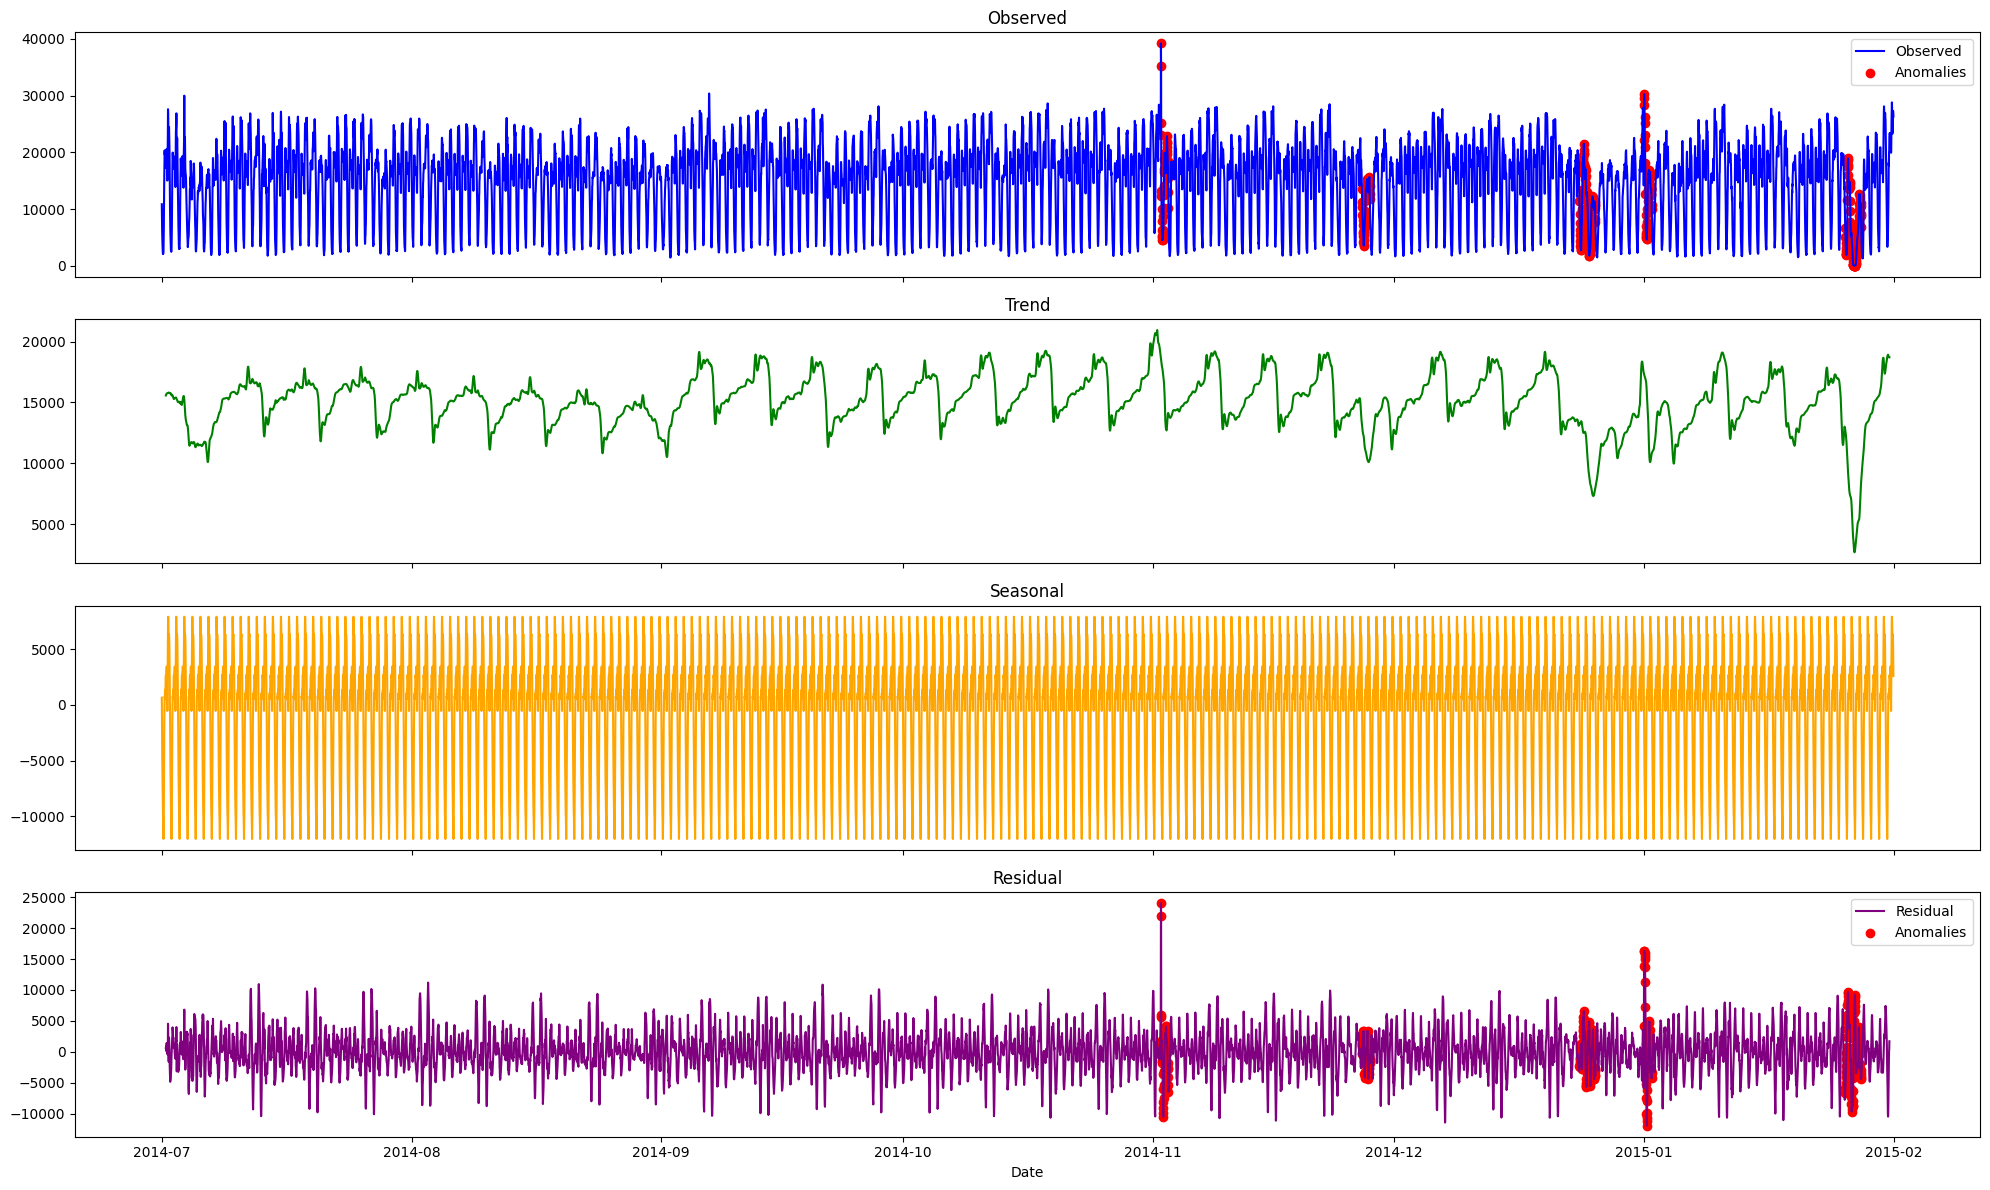

In [229]:
# Decompose the time series
temporary = dataset.copy()

decompose_result = seasonal_decompose(temporary['value'], model='additive', period=48)

# Extract components
observed = decompose_result.observed
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid
temporary['trend'] = trend
temporary['seasonal'] = seasonal
temporary['residual'] = residual

# Anomalies: Get index of anomalies
anomaly_indices = dataset.loc[dataset['isAnomaly']].index

# Plot decomposed components with anomaly highlights
fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)

# Observed
axes[0].plot(observed, label='Observed', color='blue')
axes[0].scatter(anomaly_indices, observed.loc[anomaly_indices], color='red', label='Anomalies')
axes[0].set_title('Observed')
axes[0].legend()

# Trend
axes[1].plot(trend, label='Trend', color='green')
axes[1].set_title('Trend')

# Seasonal
axes[2].plot(seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal')

# Residual
axes[3].plot(residual, label='Residual', color='purple')
axes[3].scatter(anomaly_indices, residual.loc[anomaly_indices], color='red', label='Anomalies')
axes[3].set_title('Residual')
axes[3].legend()

# Formatting
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [230]:
adf_test = adfuller(residual.dropna())
print(f"Residual Stationarity Test p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The Residual is Stationary")
else:
    print("The Residual is non-stationary")

Residual Stationarity Test p-value: 0.0
The Residual is Stationary


## Correlation, Full and Partial Autocorrelation

- In Spearman Correlation, 
    - value is correlated with: 
        - hour (0.63)
        - isAnomaly (-0.13)
        - day_of_week (0.15)
        - isHoliday (-0.10)
    - isAnomaly is correlated with:
        - isHoliday (0.35)
        - month (0.20)
        - max_temp and min_temp (-0.18 each)
        - season (0.12)
        - value (-0.13)
    - Other features are close to 0
    
- In Autocorrelation,
    - Find correlation between current val to all of the previous values in the series based on lags
    - At early lags (0 - 50): Values is very high - strongly correlated
    - At 1 week lag (336): 0.86 - Strongly correlated
    - As increased by 1 week: stay in range of 0.7 to 0.9
    - The nearest best positive correlation is at approximated 50 lags (1 day before)

- In Partial Autocorrelation,
    - Find correlation between current val to ONLY the lagged value
    - At early lags (0 - 5 approx): Values is very high - strongly correlated
    - As increase: getting smaller to closer to 0

In [231]:
# Convert categorical columns to numeric using factorize
mapping = {
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12,
    'January': 1
}
temporary['month'] = temporary['month'].map(mapping)
# Create a mapping dictionary
mapping = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6
}
# Map the series using the dictionary
temporary['day_of_week'] = temporary['day_of_week'].map(mapping)

In [232]:
# Select features for correlation (ensure valid column names)
for col in ['trend','seasonal','residual']:
    temporary[col].fillna(temporary[col].mean(),inplace = True)

features = temporary.columns

# Initialize an empty dataframe to store results
corr_df = pd.DataFrame(columns=["Target", "Feature", "Spearman Correlation", "p_value", "less than 0.05?"])

# Iterate over each target and feature to calculate Spearman correlation
for target in ['value', 'isAnomaly']:
    for feature in features:
        corr, p_value = spearmanr(temporary[target], temporary[feature])
        
        # Append the results to the DataFrame
        corr_df.loc[len(corr_df)] = {
            "Target": target,
            "Feature": feature,
            "Spearman Correlation": corr,
            "p_value": p_value,
            "less than 0.05?": p_value < 0.05
        }

# Display the result DataFrame
corr_df

C:\Users\weare\AppData\Local\Temp\ipykernel_17308\2299427853.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temporary[col].fillna(temporary[col].mean(),inplace = True)


,Target,Feature,Spearman Correlation,p_value,less than 0.05?
0,value,value,1.000000,0.000000e+00,True
1,value,month,0.048167,9.810160e-07,True
2,value,day,-0.051722,1.462888e-07,True
3,value,hour,0.628512,0.000000e+00,True
4,value,day_of_week,0.154963,1.752648e-56,True
5,value,isWeekend,0.064605,5.060914e-11,True
6,value,isAnomaly,-0.126685,3.464635e-38,True
7,value,isHoliday,-0.104834,1.290643e-26,True
8,value,min_temp,-0.016399,9.574502e-02,False
9,value,max_temp,-0.024433,1.305922e-02,True


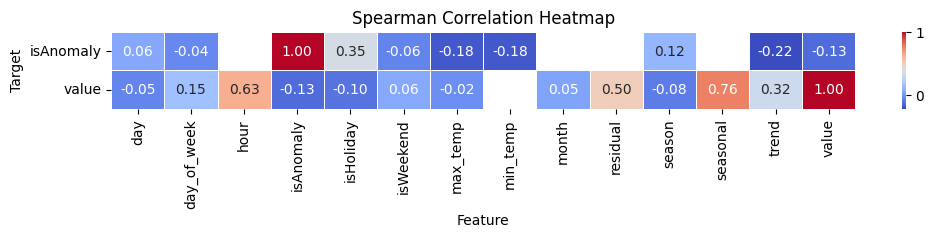

In [233]:
# Pivot the DataFrame to create a matrix of Spearman Correlations
corr_df = corr_df.loc[corr_df['less than 0.05?']]
heatmap_data = corr_df.pivot(index='Target', columns='Feature', values='Spearman Correlation')

# Create the heatmap
plt.figure(figsize=(12, 1))  # Adjust the figure size if necessary
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title and labels
plt.title('Spearman Correlation Heatmap')
plt.ylabel('Target')
plt.xlabel('Feature')

# Show the plot
plt.show()


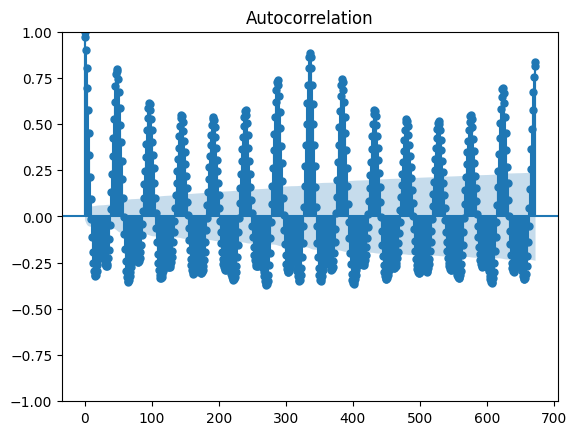

In [234]:
plot_acf(dataset['value'], lags=336 * 2)  # Adjust lags as needed
plt.show()  # Ensure the plot is shown only once

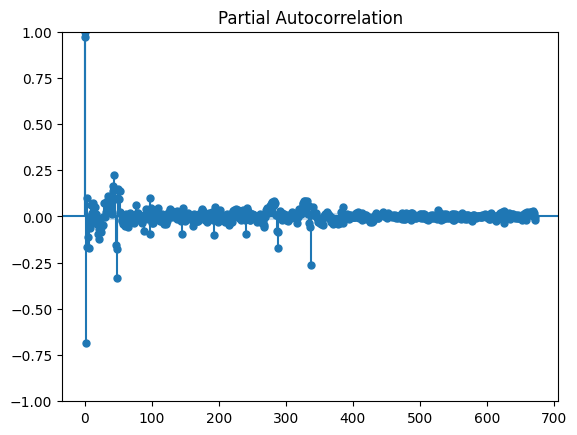

In [235]:
plot_pacf(dataset['value'], lags=336 * 2)  # Adjust lags as needed
plt.show()  # Ensure the plot is shown only once

# Questions To Ponder

- There are some hunches that there are mislabelled anomalies
    - Possibility from the unsearched holidays dates
        - The indepencedency day (4th July) - visualization only
        - The labor day (1st Sept)
        - The Colombus day (13th Oct)
        - The Election day (4th Nov)
        - The Veteran day (11th Nov)
        - Martin Luther King Jr. Day (19th Jan)
    - Possibility from the upper and lower limit
        - Upper: approx below 28k-30k
        - Lower: approx below or above 1250

- In Need to compare other anomaly detection algorithms with the current isAnomaly
    - Isolation Forest
    - DBSCAN

- Only for the Data Preprocessing Section
    - Filter out the dataset
        - to get properly best maximum of the anomalies ratio
        - by only September and above only due to the pattern on summer not the same as other seasons
        - Optional task but do not recommend doing this
    - Fill in the missing values (ie in Holiday column)
    - Remove the isAnomaly column as they may not going to be ok (Unsure but there are more anomalies than the ones stated in Kaggle)
    - Consider doing Features Engineering
        - Cyclic/Trend Features
        - Lag Features (Refer to Autocorrelation / Partial Autocorrelation)
        - Combining Features (hour + minute etc)
        - Features Selection (Please decide)
    - Splitting to Training, validation and testing dataset. Note that the data is depending on every last 7 days period
        - consider time-based splitting
        - For validation, consider walk-forward sets
    - Scaling the dataset (Please do after the splitting)
    - Notify in the group if done so that model building and testing can proceed